## Example 3: Master FLAT 

<pre> Máster en Astrofísica UCM -- Técnicas Experimentales en Astrofísica
Jaime Zamorano and Nicolás Cardiel

This notebook has reproduced parts of the STAK project notebook:
 - https://stak-notebooks.readthedocs.io/en/latest/index.html 

and the astropy tutorials: http://learn.astropy.org/FITS-images.html (by Lia R. Corrales)

v2  2020/05/14 
v3  2021/01/10 almost ready for 2020/21

Note that the ``astropy`` package should be installed. In this sense, have a look to the
astropy installation description: https://docs.astropy.org/en/stable/install.html.  
We are also using ``ccdproc`` package  
and ``photutils'' https://photutils.readthedocs.io/en/stable/install.html

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats, mad_std

import ccdproc
from ccdproc import CCDData, Combiner
from ccdproc import median_filter

import numpy as np
import numpy.ma as ma

from photutils import DAOStarFinder
from photutils import CircularAperture

In [6]:
# auxiliary function to display a rectangle and compute mean value within it
def draw_rectangle(ax, image_data, x1, x2, y1, y2, color, text=False):
    ax.plot((x1, x1), (y1, y2), color, lw=1)
    ax.plot((x2, x2), (y1, y2), color, lw=1)
    ax.plot((x1, x2), (y1, y1), color, lw=1)
    ax.plot((x1, x2), (y2, y2), color, lw=1)
    if text:
        media = image_data[y1:y2,x1:x2].mean()
        std   = image_data[y1:y2,x1:x2].std()
        ax.text((x1+x2)/2, y1+(y2-y1)/8, str(int(media)), 
                ha='center', va='top', color=color, fontsize=15)        
        ax.text((x1+x2)/2, y2, str(int(std)), 
                ha='center', va='bottom', color=color, fontsize=15)
    return media,std

In [15]:
# Some style for better looking plots
matplotlib.rcParams['text.usetex']=False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['font.size'] = 12
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 4.
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['grid.linewidth'] = 1.0
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['xtick.minor.size']=4
plt.rcParams['xtick.major.size']=8
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.major.size']=8
plt.rcParams['figure.figsize'] = 12,6
plt.rcParams['figure.subplot.bottom'] = 0.15
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10

### Opening the FITS files of Sky FLATs observations

List of files to be combined

We are using the observations at Calar Alto with CAFOS of 2019/05/10 and 2019/05/11 performed by the students of Master in Astrofísica UCM

In [30]:
# Files of Sky Flats observations
directory = 'FITS_files_flats/'
files = ['ucmP_0018.fits',
         'ucmP_0019.fits',
         'ucmP_0020.fits',
         'ucmP_0021.fits']

Opening the FITS files and putting the data into a list of numpy 2-D arrays.

In [31]:
image = []
for i in range(len(files)):
    image.append(fits.getdata(directory+files[i]))
# If you need to browse the header
#fits.getheader(directory+files[0])

Each image is now stored as a 2-D numpy arrays inside a list. 
Want to know the dimensions of the image? Just look at the shape of the array.

In [32]:
print(type(image[0]))
print(image[1].shape)
print((image[2].shape)[0])
print((image[3].shape)[1])

<class 'numpy.ndarray'>
(1301, 1301)
1301
1301


### Analysing the images data

Let us get some basic statistics about our images

In [33]:
exposure = []
mean, median = [],[]
print('Filename        Object  date&time       exposure   Mean std  Median')
for i in range(len(files)):
    header = fits.getheader(directory+files[i])
    exposure.append(header['EXPTIME'])
    median.append(np.median(image[i]))
    mean.append(np.mean(image[i]))
    print(header['FILENAME'], header['OBJECT'], header['DATE'], header['EXPTIME'],
          int(np.mean(image[i])), int(np.std(image[i])), int(np.median(image[i])))

Filename        Object  date&time       exposure   Mean std  Median
ucmP_0018.fits Sky Flat 2019-04-11T19:15:55 60.0 24224 4714 25196
ucmP_0019.fits Sky Flat 2019-04-11T19:20:50 80.0 12860 2758 13388
ucmP_0020.fits Sky Flat 2019-04-11T19:23:51 100.0 10734 2695 11133
ucmP_0021.fits Sky Flat 2019-04-11T19:27:17 120.0 7670 2421 7908


During the twilight the signal drops quickly and you should increase the exposure time. The last flats have lower median values.

### Plotting histograms to compare data

To make a histogram with ``matplotlib.pyplot.hist()``, we need to cast the data from a 2-D to array to something one dimensional. In this case, we are am using ``ndarray.flatten()`` to return a 1-D numpy array.

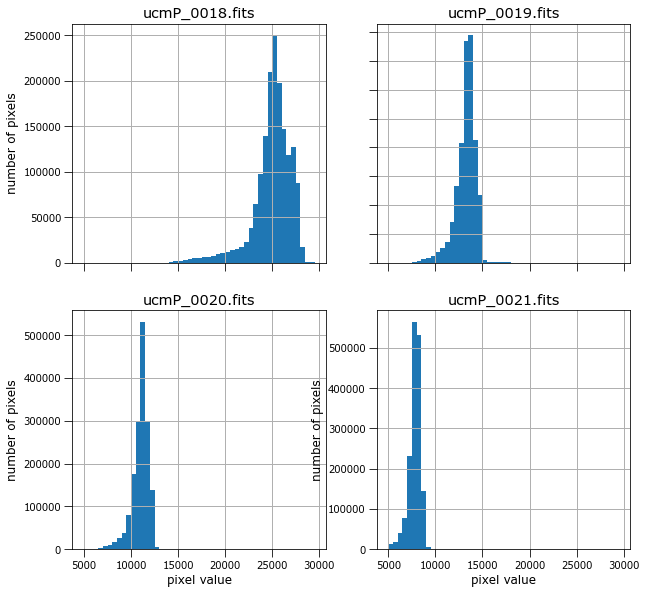

In [34]:
bins = np.arange(5000, 30000, 500)
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
k = 0
for i in range(2):
    for j in range(2):
        ax = axarr[i, j]
        ax.hist(image[k].flatten(), alpha=1, bins=bins)
        ax.grid()
        ax.set_xlabel('pixel value')
        ax.set_ylabel('number of pixels')
        ax.set_title(files[k][:])
        if k < 2:
            ax.label_outer()
        k += 1
plt.show()

The histograms show different distributions of the pixel values.
Let display the four images.

### Displaying the images  

Let display one of the flats with logaritmic scale to see details in low signal values

Text(0.5, 1.05, 'ucmP_0020.fits')

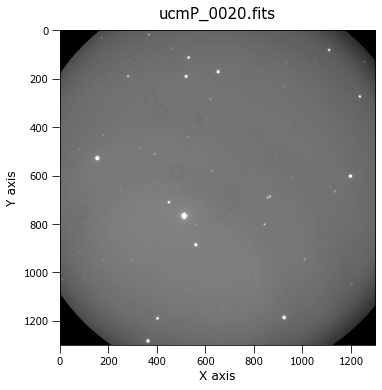

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(image[2], cmap='gray', vmin=5000, vmax=30000, norm=LogNorm())
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.text(0.5, 1.05, files[2], ha='center', va='center', color='k', transform=ax.transAxes, fontsize=15)

The image is full of stars. Let check whether this is the case for the remaining sky flats.

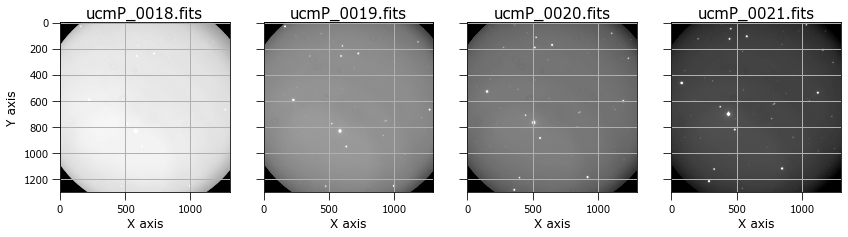

In [36]:
fig, axarr = plt.subplots(ncols=4, nrows=1, figsize=(14, 9))
for i in range(4):
    ax = axarr[i]
    ax.imshow(image[i], cmap='gray', vmin=5000, vmax=30000, norm=LogNorm())
    ax.text(0.5, 1.05, files[i], ha='center', va='center', color='k', transform=ax.transAxes, fontsize=15)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    if i > 0:
        ax.label_outer()
    ax.grid()

The stars do not appear at the same place of the consecutive images as the observer moved the pointing between exposures. Let display now a region in the center of the field of view to appreciate these shifs.

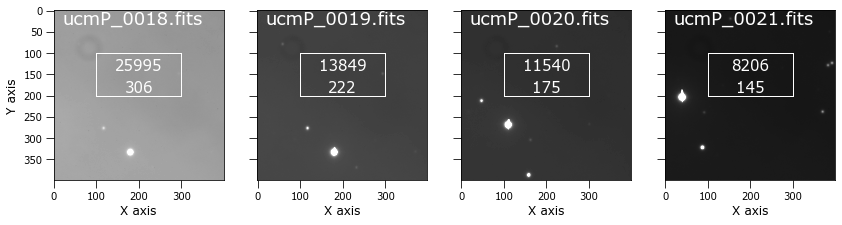

In [37]:
fig, axarr = plt.subplots(ncols=4, nrows=1, figsize=(14, 6))
for i in range(0,4):
    ax = axarr[i]
    box = image[i][500:900, 400:800]
    ax.imshow(box, cmap='gray', vmin=5000, vmax=40000) #,norm=LogNorm())
    ax.text(0.05, 0.95, files[i], ha='left', va='center', color='w', transform=ax.transAxes, fontsize=18)
    draw_rectangle(ax, box , 100,300, 100, 200, color='w', text=True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    if i > 0:
        ax.label_outer()
    #ax.grid()

There is no shift between the first and second exposure. This could be a problem.

### Zero correction  

Before performing any combination of the sky flats we should correct from BIAS.
We are using the master DARK obtained in the pevious example.
Let use the second sky flat as example

In [38]:
dark_file = 'N1_master_dark.fits'
dark_image = fits.getdata(dark_file)
zimage = image[1] - dark_image

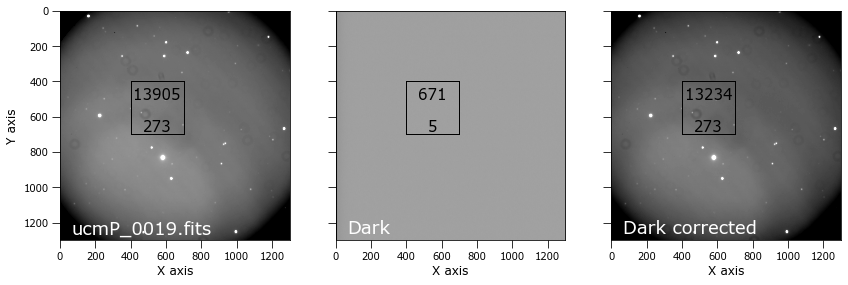

In [39]:
fig, axarr = plt.subplots(ncols=3, nrows=1, figsize=(14, 6))
for i in range(0,3):
    ax = axarr[i]
    if i==0:
        box = image[1]
        label = files[1]
        vmin,vmax = 10000,20000
    if i==1:  
        box = dark_image   
        label = 'Dark'
        vmin,vmax = 500,800
    if i==2:  
        box = zimage   
        label = 'Dark corrected'
        vmin,vmax = 10000,20000
    ax.imshow(box, cmap='gray', vmin=vmin, vmax=vmax, norm=LogNorm())
    ax.text(0.05, 0.05,label, ha='left', va='center', color='w', transform=ax.transAxes, fontsize=18)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    draw_rectangle(ax, box , 400, 700, 400, 700, color='k', text=True)
    if i > 0:
        ax.label_outer()

The original and BIAS corrected imege looks similar but the pixels values are slightly lower. 

### Combining the Sky FLATS images

A typical combination of the sky flats will have problems to get rid of the stars because of the small number of exposures. 

We can use a wise approach by detecting and masking the images of the stars in the individual frames before combining. 

See: https://photutils.readthedocs.io/en/stable/background.html

In [40]:
# Working with one of the images
print('Original flat           median: ', np.median(image[1]))
mean, median, std = sigma_clipped_stats(image[1], sigma=3.0)
print('after sigma clipping    median: ', median, '   mean', round(mean,1), '   std', round(std,1))
ximage = median_filter(image[1], 20)
print('after median filter     median: ', np.median(ximage))

Original flat           median:  13388.0
after sigma clipping    median:  13450.0    mean 13362.5    std 813.4
after median filter     median:  13404.0


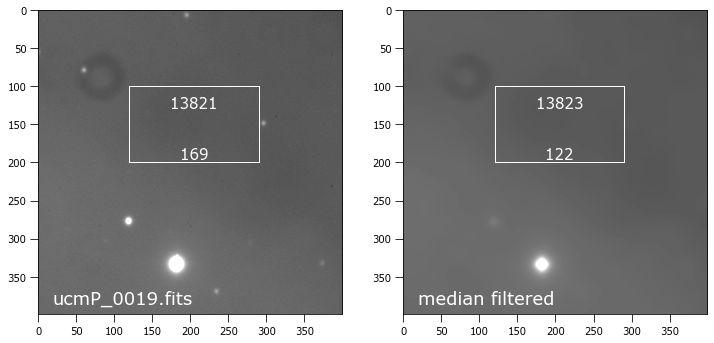

In [41]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

for i in range(2):
    ax = axarr[i]
    if i==0:
        box = image[1][500:900, 400:800]
        label = files[1]
        vmin,vmax = 10000, 25000
    if i==1:  
        box = ximage[500:900, 400:800]  
        label = 'median filtered'
    vmin,vmax = 10000,25000
    ax.imshow(box, cmap='gray', vmin=vmin, vmax=vmax, norm=LogNorm())
    ax.text(0.05, 0.05,label, ha='left', va='center', color='w', transform=ax.transAxes, fontsize=18)
    draw_rectangle(ax, box , 120,290, 100, 200, color='w', text=True)

Even using a median filter of 20 pixels there are images of stars remaining.

### Combination after masking the star images

In [46]:
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)  
sources = daofind(image[1] - median)  
for col in sources.colnames:  
     sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid sharpness  ... sky  peak    flux       mag     
--- --------- --------- ---------- ... --- ----- --------- ------------
  1 954.19215 4.7355046 0.53365277 ...   0 52085 34.766737   -3.8529098
  2  1171.204 12.451309 0.35563439 ...   0 -5448 2.3949684  -0.94824945
  3 160.80231 33.457542 0.38694906 ...   0 52085 45.446726   -4.1437565
  4  1216.193 51.954502  0.2430225 ...   0 -3819 2.6267291   -1.0485382
  5 436.84706 89.052209 0.60288149 ...   0  7689 5.4813193   -1.8472128
  6 243.61181 101.90308 0.60733518 ...   0  2360 2.1115313   -0.8114938
  7 532.28504 146.65107 0.53263104 ...   0  2712 2.0999052   -0.8054992
  8 1178.8218 151.27008 0.63482409 ...   0 24814 17.011312   -3.0768445
  9  599.8479 182.26971 0.65820183 ...   0 39110 24.285908   -3.4633859
 10 1003.6423 201.69693 0.70119979 ...   0  1166 1.1184326  -0.12152453
...       ...       ...        ... ... ...   ...       ...          ...
 35 633.53615 869.75005 0.72862308 ...   0  5013  2.144453  -0.8

With fwhm=10.0, threshold=5.*std  ``DAOStarFinder'' finds 45 images of stars.  
We can display the sky flat with the detected sources marked.

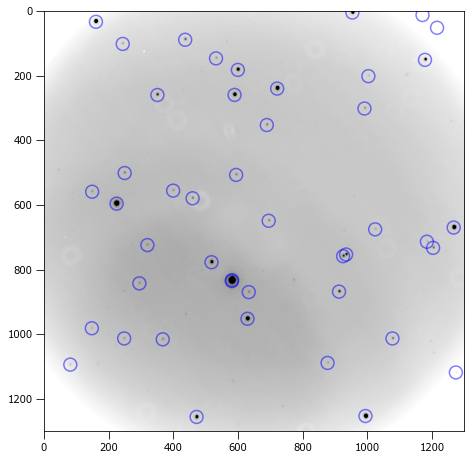

In [48]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=20.)
plt.figure(figsize=(8,8))
plt.imshow(image[1], cmap='Greys', vmin=vmin, vmax=vmax, norm=LogNorm())
apertures.plot(color='blue', lw=1.5, alpha=0.5)

#### Masking Regions 
Regions of the input image can be masked by using the numpy  ``command ma.array''

In [49]:
masked_image = image[1]
naxis2, naxis1 = masked_image.shape
mask = np.zeros((naxis2, naxis1), dtype=bool)
semiwidth = 10

for i in range(len(positions)):
    x, y = int(positions[i][0]), int(positions[i][1])
    xmin = max(0, x - semiwidth)
    xmax = min(naxis1, x + semiwidth)
    ymin = max(0, y - semiwidth)
    ymax = min(naxis2, y + semiwidth)
    
    #mask[x-10:x+10, y-10:y+10] = False
    mask[ymin:ymax, xmin:xmax] = 1

#masked_image = image[1]*mask
masked_image = ma.array(image[1],mask=mask)

We will show the original image, the mask applied and the resulting masked numpy array.

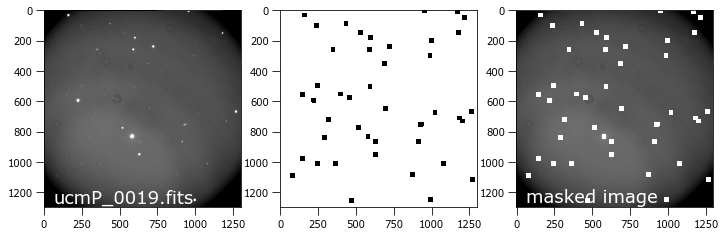

In [50]:
fig, axarr = plt.subplots(ncols=3, nrows=1, figsize=(12, 6))

for i in range(3):
    ax = axarr[i]
    if i==0:
        box = image[1]  #[500:900, 400:800]
        label = files[1]
    if i==2:  
        box = masked_image  #[500:900, 400:800]  
        label = 'masked image'
    if i==1:  
        box = mask   #[500:900, 400:800]  
        label = ''
    vmin,vmax = 10000,25000
    ax.imshow(box, cmap='gray', vmin=vmin, vmax=vmax, norm=LogNorm())
    ax.text(0.05, 0.05,label, ha='left', va='center', color='w', transform=ax.transAxes, fontsize=18)

In [52]:
# We need to read again the files with the sky flats observations 
# to create CCDData objects
# https://docs.astropy.org/en/stable/nddata/ccddata.html
flats = []
for file in files:
    images = CCDData.read(directory+file, unit="adu")
    flats.append(images)
dark_image = CCDData.read('N1_master_dark.fits', unit="adu")

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Lets correct the flats from the BIAS signal

In [53]:
# Combiner is a class for combining CCDData objects.
# https://ccdproc.readthedocs.io/en/latest/api/ccdproc.Combiner.html
# The Combiner class is used to combine together CCDData objects 
# including the method for combining the data, rejecting outlying data, 
# and weighting used for combining frames.

combiner = Combiner(flats)

In [54]:
for file in flats:
    file = ccdproc.subtract_bias(file, dark_image)

#### Masking stars in flats

In [55]:
x_flats = []      # masked Flats as numpy 2D array
semiwidth = 15

for i in range(len(files)):
    mean, median, std = sigma_clipped_stats(flats[i], sigma=3.0)
    daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)
    sources = daofind(flats[i] - median)  
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=20.)
    mask = np.zeros(flats[i].shape, dtype=bool)
    for j in range(len(positions)):
        x, y = int(positions[j][0]),int(positions[j][1])
        xmin = max(0, x - semiwidth)
        xmax = min(naxis1, x + semiwidth)
        ymin = max(0, y - semiwidth)
        ymax = min(naxis2, y + semiwidth)
        mask[ymin:ymax, xmin:xmax] = 1        
    x_flats.append(ma.array(flats[i],mask=mask))
    print('flat ',i,'completed')

flat  0 completed
flat  1 completed
flat  2 completed
flat  3 completed


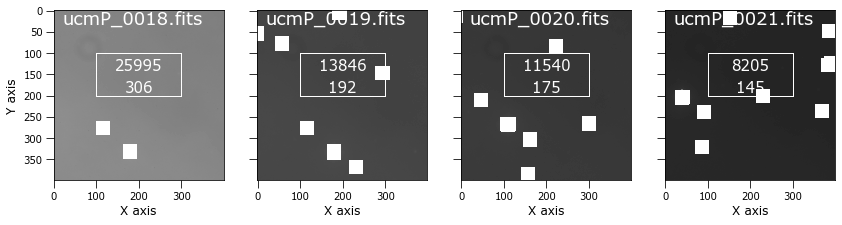

In [56]:
fig, axarr = plt.subplots(ncols=4, nrows=1, figsize=(14, 6))
vmin,vmax = 1000, 50000
for i in range(0,4):
    ax = axarr[i]
    box = x_flats[i][500:900,400:800]
    ax.imshow(box, cmap='gray', vmin=vmin, vmax=vmax) #,norm=LogNorm())
    ax.text(0.05, 0.95,files[i], ha='left', va='center', color='w', transform=ax.transAxes, fontsize=18)
    draw_rectangle(ax, box , 100, 300, 100, 200, color='w', text=True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    if i > 0:
        ax.label_outer()

In [57]:
masked_flats = []     # masked Flats as numpy CCDData
for i in range(len(flats)):
    masked_flats.append(CCDData(x_flats[i], unit="adu"))

In [58]:
# Combiner is a class for combining CCDData objects.
# https://ccdproc.readthedocs.io/en/latest/api/ccdproc.Combiner.html
# The Combiner class is used to combine together CCDData objects 
# including the method for combining the data, rejecting outlying data, 
# and weighting used for combining frames.

combiner = Combiner(masked_flats)

In [59]:
# We will scale the Sky Flats acoording to the inverse of the median value. 
scale = []
for file in masked_flats:
    scale.append(1/ np.median(file))
print(scale)

[3.968883949833307e-05, 7.469375560203167e-05, 8.982304859426928e-05, 0.00012645422357106728]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [60]:
# ccdproc.combine
master_flat = ccdproc.combine(masked_flats,method='median', scale=scale,sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std)
#combiner.scaling = scale
#combiner.clip_extrema(nlow=1, nhigh=0)
#master_flat2 = combiner.median_combine()

Let display a region of one of the Sky Flats images and the master Sky FLAT

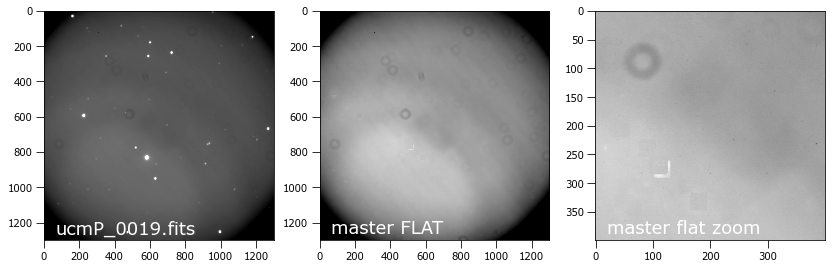

In [61]:
fig, axarr = plt.subplots(ncols=3, nrows=1, figsize=(14, 6))
for i in range(3):
    ax = axarr[i]
    if i==0:
        box = np.asarray(flats[1])#[500:900,400:800])
        label = files[1]
        vmin,vmax = 10000,25000
    if i==1:  
        box = np.asarray(master_flat)#[500:900,400:800])   # We need to convert CCDdata to np.array
        label = 'master FLAT'
        vmin,vmax = 0.8,1.2
    if i==2:  
        box = np.asarray(master_flat[500:900,400:800])   # We need to convert CCDdata to np.array
        label = 'master flat zoom '
        vmin,vmax = 0.8,1.2
    ax.imshow(box, cmap='gray', vmin=vmin, vmax=vmax,norm=LogNorm())
    ax.text(0.05, 0.05,label, ha='left', va='center', color='w',transform=ax.transAxes,fontsize=18)

In [62]:
for i in range(len(flats)):
    flats[i] = flats[i]/np.median(flats[i])

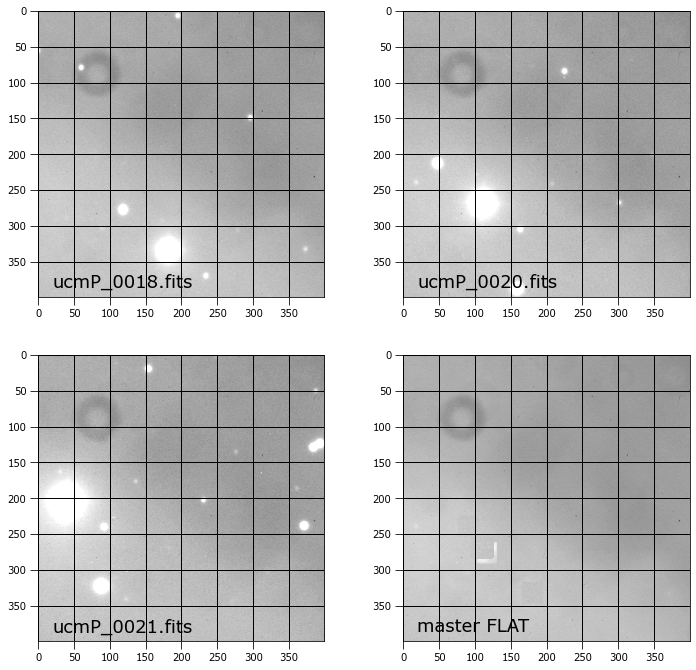

In [63]:
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
vmin,vmax = 0.8,1.2
k=0
for i in range(2):
    for j in range(2):
        ax = axarr[i,j]
        if k==0:
            box = flats[1][500:900,400:800]
            label = files[0]
        if k==1:
            box = flats[2][500:900,400:800]
            label = files[2]
        if k==2:  
            box = flats[3][500:900,400:800]   # We need to convert CCDdata to np.array
            label = files[3]
        if k==3:  
            box = np.asarray(master_flat[500:900,400:800])   # We need to convert CCDdata to np.array
            label = 'master FLAT'
        k += 1
        ax.imshow(box, cmap='gray', vmin=vmin, vmax=vmax,norm=LogNorm())
        ax.text(0.05, 0.05,label, ha='left', va='center', color='k',transform=ax.transAxes,fontsize=18)
        ax.grid(color='k')

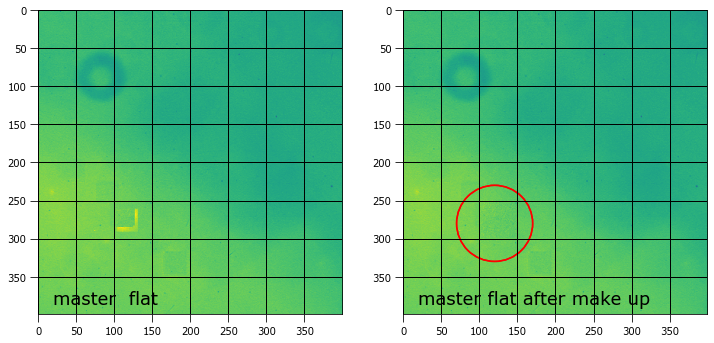

In [65]:
x_master_flat = np.asarray(master_flat).copy()
x_master_flat[750:800,500:550]=np.asarray(flats[3][750:800,500:550])
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 12))
vmin,vmax = 0.8,1.2
aperture = CircularAperture([120,280], r=50.)
for i in range(2):
    ax = axarr[i]
    if i==0:
        box = np.asarray(master_flat[500:900,400:800])
        label = 'master  flat'
    if i==1:  
        box = np.asarray(x_master_flat[500:900,400:800])   # We need to convert CCDdata to np.array
        label = 'master flat after make up'
    ax.imshow(box, vmin=vmin, vmax=vmax,norm=LogNorm())
    ax.text(0.05, 0.05,label, ha='left', va='center', color='k',transform=ax.transAxes,fontsize=18)
    aperture.plot(color='red', lw=1.5, alpha=1)
    ax.grid(color='k')

#### Writing the resulting image as FITS file

We can write the resulting file to a FITS file. We wish to maintain the information of the header (metadata) and also add some information 

In [66]:
# Extract primary header from single dark file and copy into master_dark header
HDUList_object = fits.open(directory+files[0])
master_flat.header = HDUList_object[0].header

In [67]:
# Replace FILENAME keyword and add information
master_flat.header['FILENAME'] = 'master_flat_R.fits' 
master_flat.header['HISTORY'] = 'super FLAT combining '+str(len(files))+'Sky Flats images'
master_flat.header['HISTORY'] = 'FLATS images from '+str(files[0])+' to '+str(files[-1])

In [68]:
# Finally writte the image to a FITS file. An error occurs when the file already exits.
fits.writeto('N1_master_flat_R.fits', x_master_flat, master_flat.header,overwrite='yes')